In [ ]:
# Import necessary libraries for data manipulation, visualization, and modeling.
import matplotlib.pyplot as plt # Library for creating visualizations such as plots
import pandas as pd # Library for data manipulation and analysis using DataFrames
import numpy as np # Library for numerical operations and array handling
from xgboost import XGBRegressor # XGBoost regressor for gradient boosting-based regression
from sklearn.metrics import mean_squared_error # Metric to evaluate regression model performance
import seaborn as sns # Library for enhanced data visualization, e.g., scatter plots
from sklearn.preprocessing import StandardScaler # Tool for standardizing feature scales
from sklearn.model_selection import train_test_split # Utility to split data into training and testing sets

In [ ]:
# Load the training and testing datasets
data= pd.read_csv('train.csv') # Read the training dataset from a CSV file
data_sub = pd.read_csv('test.csv') # Read the test dataset for predictions

In [ ]:
# Preprocess the data by removing irrelevant columns
data_x_drop = data.drop(['id','production_date','production_time','operator_id','machine_id','quality_score'],axis =1)
data_y = data['quality_score'] # Extract the target variable (quality_score) for training
data_sub_drop = data_sub.drop(['id','production_date','production_time','operator_id','machine_id'],axis=1)
data_x_drop.head() # Display the first five rows of the preprocessed training features

plate_thickness  plate_length  min_luminosity  defect_area  \
0         4.370861     45.427197        3.736408    24.983512   
1         9.556429     52.609209        3.329121    37.337339   
2         7.587945     86.909265        1.761539    28.133339   
3         6.387926     40.600395        6.072667     4.165129   
4         2.404168     88.268472        4.766242     9.279012   

   brightness_index  edge_index  square_index  total_luminosity  cooling_rate  \
0          7.299983    0.461854      6.381446        628.922999     18.451042   
1          1.845120    0.303769      4.592925         86.958294      9.266800   
2          3.466397    3.020960      9.644985        631.647324     10.686165   
3          6.632806    4.830582      2.189785        135.185176     13.130201   
4          4.820893    2.513607      5.878564        724.827027     14.164400   

   processing_time  temperature  
0       231.972962  1923.618289  
1       426.695368  1747.258522  
2       497.750727  1597.732805  
3       436.304615  1868.320893  
4       238.457171  1709.339068

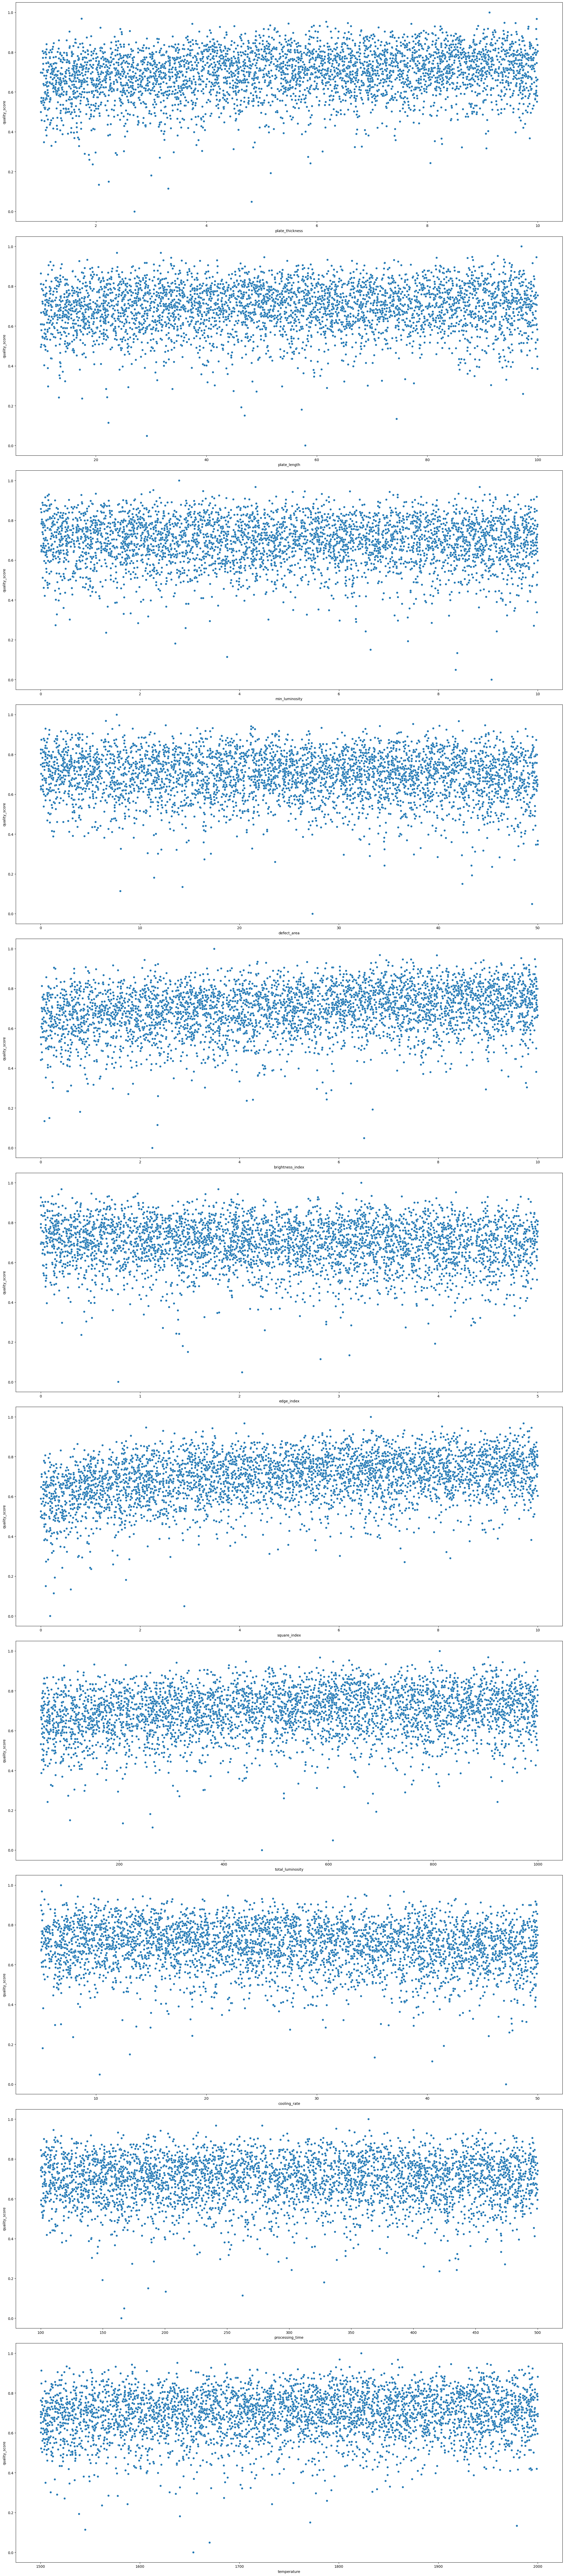

In [ ]:
#This section creates scatter plots to visualize the relationship between each feature in the dataset and the target variable (quality_score).
#  By plotting each feature against the target, we can identify potential patterns, correlations, or non-linear relationships that may inform model selection and feature engineering.
#  The use of plt.subplots creates a grid of plots for better organization, and tight_layout ensures proper spacing.
fig, axes = plt.subplots(11,1 , figsize=(22, 100)) # Create a grid of 11 subplots to visualize feature relationships with the target variable


for i in range(min(len(data_x_drop.columns),11)):
    sns.scatterplot(data=data_x_drop, x=data_x_drop.columns[i], y=data_y, ax=axes[i])
# Plot each feature against quality_score on the corresponding subplot
plt.tight_layout() # Optimize spacing between subplots for clear visualization
plt.show() # Display the scatter plots


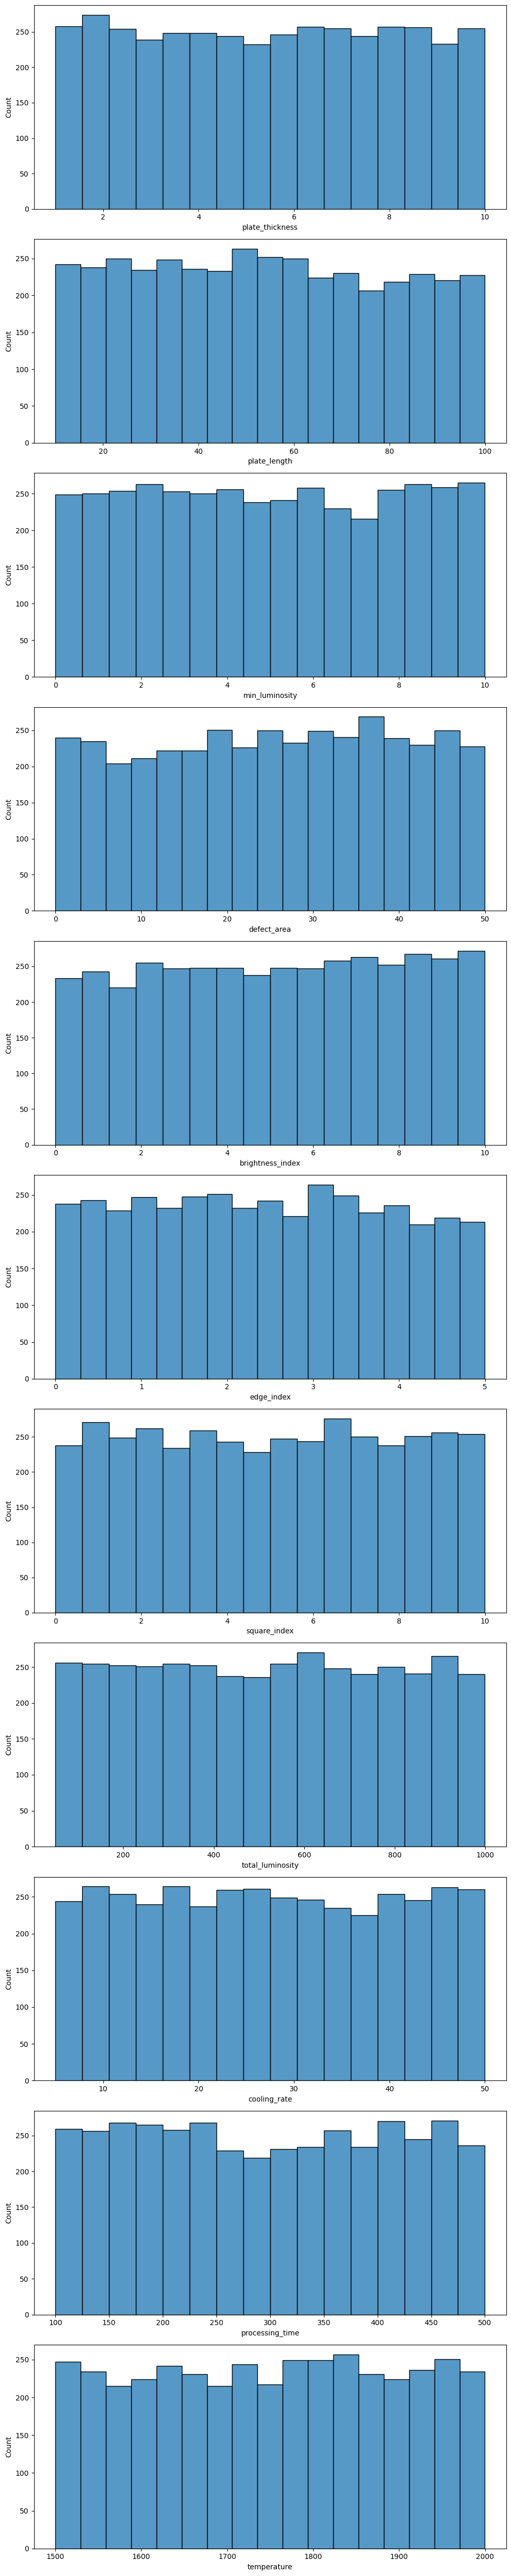

In [ ]:
#This section generates histograms to visualize the distribution of each feature in the dataset (data_x_drop).
#  Histograms help identify the shape of the data distribution (e.g., normal, skewed, or multimodal), which is crucial for understanding feature characteristics, detecting outliers, and deciding on preprocessing steps like scaling or transformation.
#  The use of plt.subplots organizes the histograms in a vertical grid, and tight_layout ensures clear and non-overlapping visualizations.
fig, axes = plt.subplots(11,1 , figsize=(10, 50))


for i in range(min(len(data_x_drop.columns),11)):
    sns.histplot(data=data_x_drop, x=data_x_drop.columns[i], ax=axes[i])

plt.tight_layout()
plt.show()


In [ ]:
# SThis section standardizes the feature data using StandardScaler to ensure all features have a mean of 0 and a standard deviation of 1.
#  Standardization is crucial for machine learning models (e.g., linear regression or XGBoost) as it ensures that features with different scales (e.g., plate_thickness vs. total_luminosity) contribute equally to the model, improving convergence and performance.
#  The training data is fit and transformed, while the test data is only transformed to maintain consistency.
scale =StandardScaler()
data_x_drop1 = scale.fit_transform(data_x_drop)

data_sub_scale = scale.transform(data_sub_drop)
data_x_drop = pd.DataFrame(data_x_drop1, columns=data_x_drop.columns)

In [ ]:
# This line splits the dataset into training and validation sets using train_test_split.
#  The split allows the model to be trained on one subset of the data (X_train, y_train) and evaluated on a separate subset (X_val, y_val) to assess its generalization performance.
#  A test size of 20% (test_size=0.2) allocates 80% of the data for training and 20% for validation, while random_state=42 ensures reproducibility of the split.
X_train,X_val,y_train,y_val = train_test_split(data_x_drop,data_y,test_size=0.2,random_state=42)

In [ ]:
#This section converts the training and validation feature sets (X_train and X_val), which are typically NumPy arrays after splitting, back into pandas DataFrames with the original column names from data_x_drop.
#  This ensures that the feature names are preserved, facilitating further analysis, visualization, or debugging, and maintaining consistency with the original dataset structure.
X_train = pd.DataFrame(X_train,columns=data_x_drop.columns)
X_val = pd.DataFrame(X_val,columns=data_x_drop.columns)

In [ ]:
#This section adds the target variable (y_train) as a new column (quality_score) to the training feature set (X_train), likely to facilitate exploratory data analysis (EDA) or visualization by combining features and the target in a single DataFrame.
#  It then checks for missing values in y_train using isna().sum() to ensure data quality, as missing values in the target variable can significantly impact model training and performance evaluation.
X_train['quality_score'] = y_train
y_train.isna().sum()

np.int64(0)

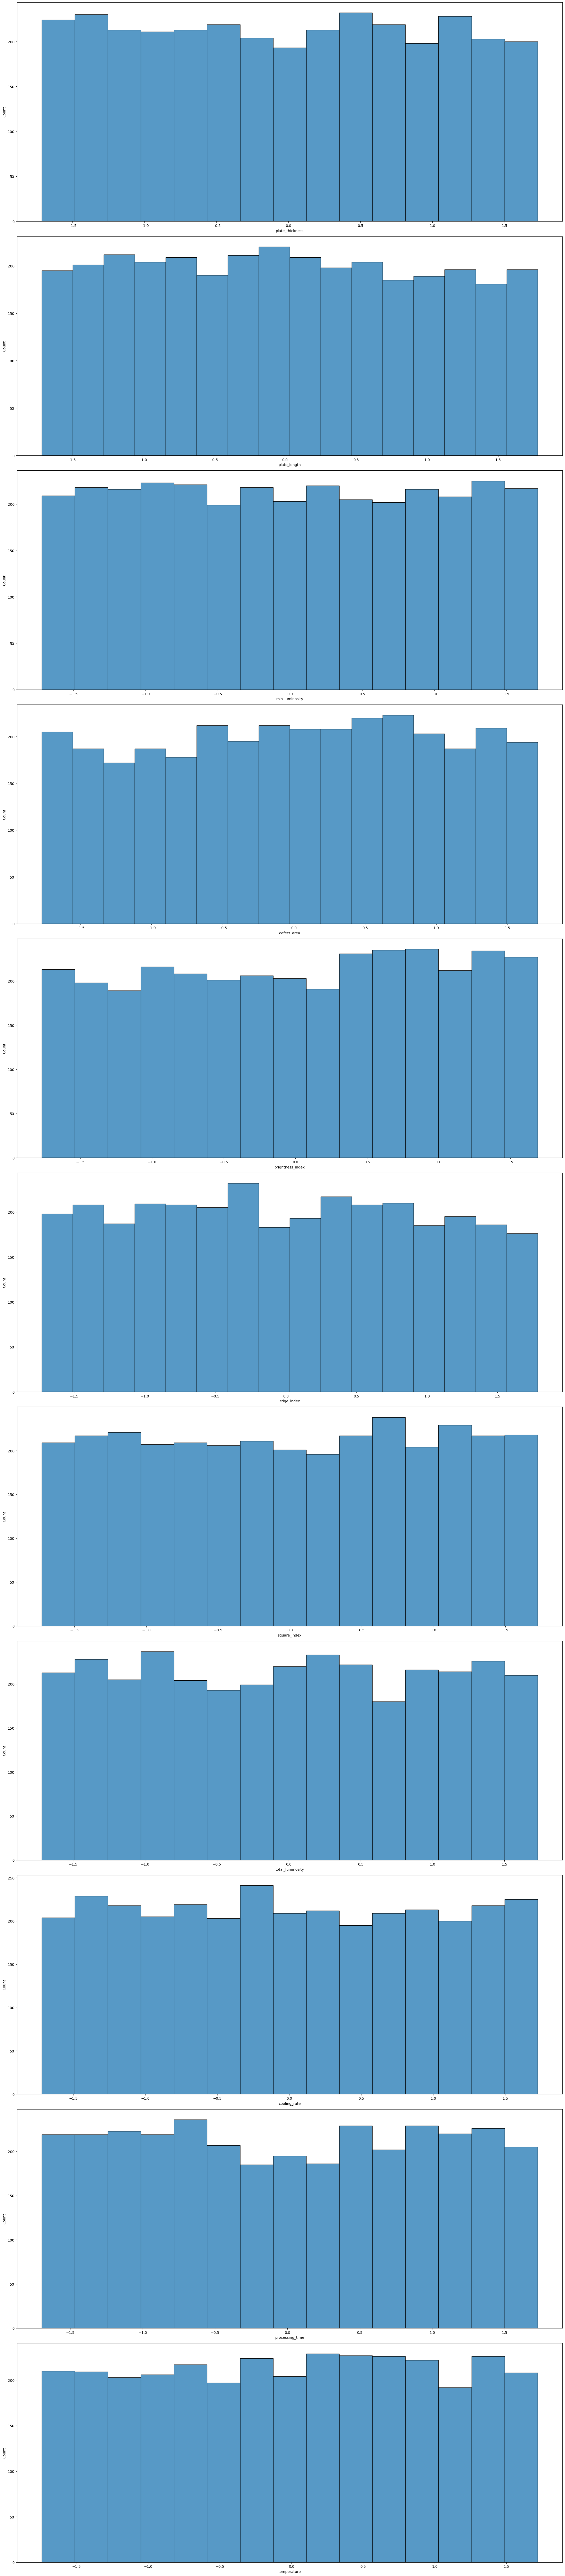

In [ ]:
fig, axes = plt.subplots(11,1 , figsize=(22, 100))


for i in range(min(len(X_train.columns),11)):
    sns.histplot(data=X_train, x=X_train.columns[i],ax=axes[i])

plt.tight_layout()
plt.show()


In [ ]:
#This section uses the EllipticEnvelope algorithm to detect outliers in the training dataset (X_train).
#  The algorithm assumes the data follows a Gaussian distribution and identifies outliers as points that lie outside an estimated elliptical boundary.
#  A contamination rate of 0.07 indicates that 7% of the data is expected to be outliers. The detected outliers are labeled in a new column (is_noise), where -1 (outlier) is mapped to 1 and 1 (inlier) to 0 for clarity.
#  Checking the counts of outliers and inliers helps assess the extent of noise in the data, which is critical for ensuring model robustness.
from sklearn.covariance import EllipticEnvelope # Library for detecting outliers assuming a Gaussian distribution

# contamination = [0.05,0.07,0.1,0.15]
envelope = EllipticEnvelope(contamination=0.07, random_state=42) # Set up outlier detection with 7% expected outliers and reproducible results
X_train['is_noise'] = envelope.fit_predict(X_train.drop('quality_score', axis=1)) # Fit the model and predict outliers, labeling them in a new 'is_noise' column


X_train['is_noise'] = X_train['is_noise'].map({1: 0, -1: 1}) # Convert labels for clarity: inliers (1) to 0, outliers (-1) to 1

print(X_train['is_noise'].value_counts()) # Show the distribution of inliers (0) and outliers (1) to assess data noise


is_noise
0    2976
1     224
Name: count, dtype: int64


Detecting Hidden Noise in Data

In [ ]:
#This line removes outliers from the training dataset (X_train) by filtering out rows where the is_noise column equals 1, retaining only inliers (where is_noise is 0).
#  Removing outliers is crucial for improving model performance, as outliers can negatively impact models like linear regression by introducing noise and skewing predictions.
#  This step ensures a cleaner dataset for training, enhancing the robustness and accuracy of the model.

X_train = X_train[X_train['is_noise'] == 0]

In [ ]:
#This line checks for missing values in each column of the training dataset (X_train) by calculating the sum of missing entries.
#  Verifying the absence of missing values is a critical step in data preprocessing, as missing data can adversely affect model training and performance, especially for models like linear regression or XGBoost.
#  This step ensures data quality after preprocessing steps like outlier removal.
X_train.isna().sum()

plate_thickness     0
plate_length        0
min_luminosity      0
defect_area         0
brightness_index    0
edge_index          0
square_index        0
total_luminosity    0
cooling_rate        0
processing_time     0
temperature         0
quality_score       0
is_noise            0
dtype: int64

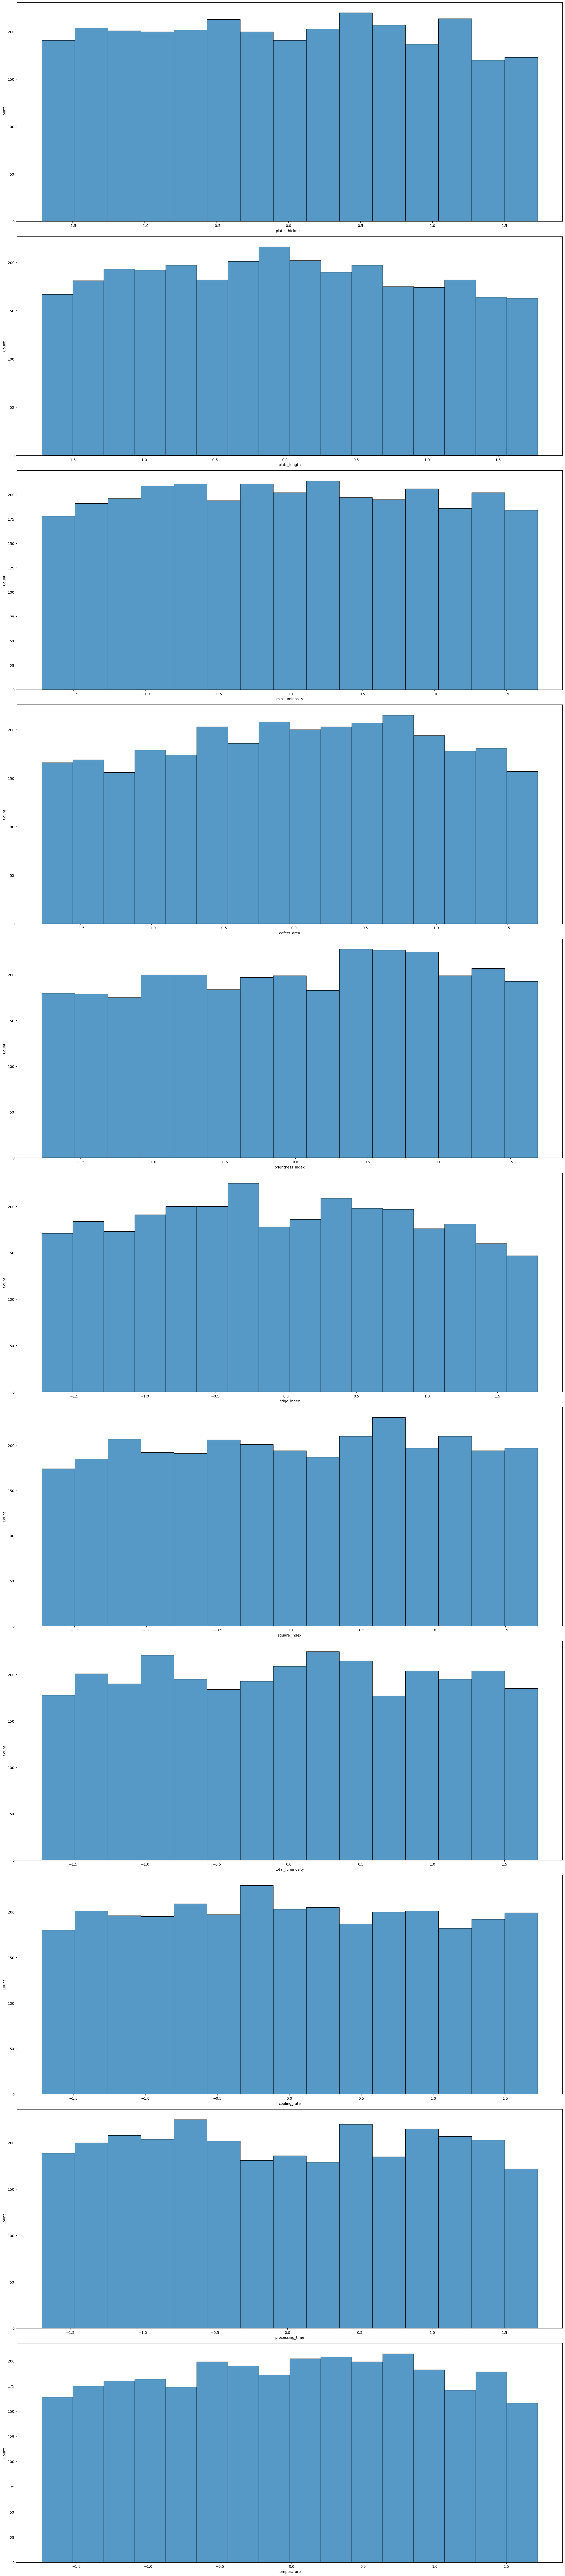

In [ ]:
fig, axes = plt.subplots(11,1 , figsize=(22, 100))


for i in range(min(len(X_train.columns),11)):
    sns.histplot(data=X_train, x=X_train.columns[i],ax=axes[i])

plt.tight_layout()
plt.show()


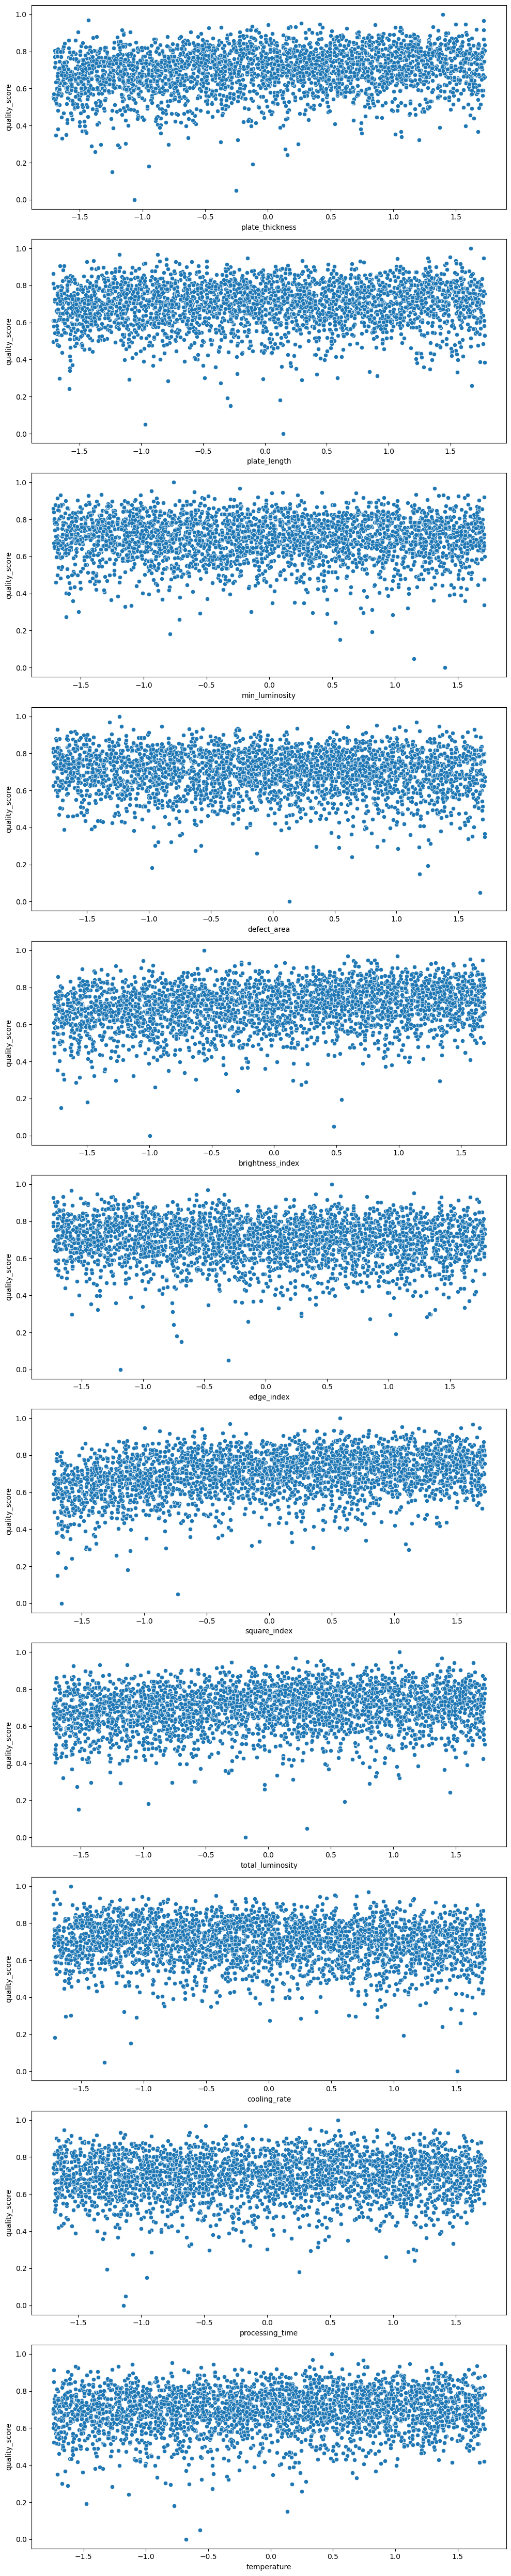

In [ ]:
fig, axes = plt.subplots(11,1, figsize=(10, 50))

for i in range(min(len(X_train.columns),11)):  
    sns.scatterplot(data=X_train, x=X_train.columns[i], y=X_train['quality_score'], ax=axes[i])

plt.tight_layout()
plt.show()

In [ ]:
#This section extracts the target variable (quality_score) from X_train to update y_train, ensuring it aligns with the filtered training data after outlier removal.
#  It then removes the is_noise and quality_score columns from X_train to prepare a clean feature set for model training.
#  This step is critical to separate features from the target variable and remove auxiliary columns, ensuring the training data contains only relevant predictors for the model.
y_train = X_train['quality_score']
X_train = X_train.drop(['is_noise','quality_score'],axis=1)

In [ ]:
#This section imports libraries and machine learning models for building and evaluating a regression pipeline.
#  Optuna is used for hyperparameter optimization, while Ridge, ElasticNet, LinearRegression, XGBRegressor, and SVR provide a variety of regression models to predict the target variable (quality_score).
#  StackingRegressor enables combining multiple models for improved performance. KFold, RepeatedKFold, and cross_val_score facilitate robust model evaluation through cross-validation, and mean_squared_error serves as a performance metric.
#  These tools are essential for optimizing and comparing models in a Kaggle competition.
import optuna
from sklearn.linear_model import Ridge,ElasticNet,LinearRegression
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score,RepeatedKFold
from sklearn.metrics import make_scorer
from sklearn.svm import SVR

In [ ]:
#This section defines two functions (xgb_fitnes and svr_fitnes) to optimize hyperparameters for XGBRegressor and SVR models using Optuna. Each function specifies a range of hyperparameters to test, evaluates model performance using 5-fold cross-validation with mean squared error (MSE) as the metric, and returns the negative mean MSE for minimization.
#  The Optuna studies run 300 trials to find the best hyperparameters, and the best RMSE (square root of the best objective value) is printed to assess model performance.
#  This hyperparameter tuning is critical for maximizing model accuracy in a Kaggle competition.

def xgb_fitnes(trial:optuna):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    

    model = XGBRegressor(**params,random_state=42,n_jobs=-1,tree_method='gpu_hist', predictor='gpu_predictor')

    cv = KFold(n_splits=5,  shuffle=True, random_state=42)

    score = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring='neg_mean_squared_error')

    return -np.mean(score)


xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_fitnes,n_trials=300,n_jobs=-1)
print(f'xgb done and best rsme:{np.sqrt(xgb_study.best_value)}')


def svr_fitnes(trial:optuna):
    params = {
        'C' : trial.suggest_float('svr_C', 0.1, 100.0, log=True),
        'gamma' : trial.suggest_float('svr_gamma', 1e-4, 1.0, log=True),
        'epsilon' : trial.suggest_float('svr_epsilon', 0.01, 1.0),
        'kernel' : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }

    cv = KFold(n_splits=5,  shuffle=True, random_state=42)
    
    model = SVR(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring='neg_mean_squared_error')

    return -np.mean(score)


svr_study = optuna.create_study(direction='minimize')
svr_study.optimize(svr_fitnes,n_trials=300,n_jobs=-1)

print(f'svr done and best rsme:{np.sqrt(svr_study.best_value)}')



[I 2025-05-12 13:52:31,747] A new study created in memory with name: no-name-9a7606de-4cb4-4fbb-b40c-ca1f57ac8444
[I 2025-05-12 13:52:47,264] Trial 2 finished with value: 0.012666340317797384 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.06036942665345565, 'subsample': 0.9, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 1.961983856578573, 'reg_alpha': 0.1479283587805792, 'reg_lambda': 0.29521240202155374}. Best is trial 2 with value: 0.012666340317797384.
[I 2025-05-12 13:52:49,363] Trial 9 finished with value: 0.01304011352114719 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.12254394191773779, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 10, 'gamma': 2.7086267708988743, 'reg_alpha': 0.757596075640878, 'reg_lambda': 0.1960158668849079}. Best is trial 2 with value: 0.012666340317797384.
[I 2025-05-12 13:52:57,028] Trial 3 finished with value: 0.012561240759419293 and parameters: {'n_estimators': 300, 'max_

xgb done and best rsme:0.0976884633616775


[I 2025-05-12 14:25:18,432] Trial 9 finished with value: 0.05025528612185622 and parameters: {'svr_C': 23.113662148380573, 'svr_gamma': 0.00035161075332786756, 'svr_epsilon': 0.9054485956351922, 'kernel': 'rbf'}. Best is trial 9 with value: 0.05025528612185622.
[I 2025-05-12 14:25:18,462] Trial 5 finished with value: 0.05025528612185622 and parameters: {'svr_C': 11.178047001798205, 'svr_gamma': 0.032508897695950285, 'svr_epsilon': 0.828969999237961, 'kernel': 'poly'}. Best is trial 9 with value: 0.05025528612185622.
[I 2025-05-12 14:25:18,488] Trial 7 finished with value: 0.0499897582137504 and parameters: {'svr_C': 8.064244096740124, 'svr_gamma': 0.037210694477802134, 'svr_epsilon': 0.48376701576708353, 'kernel': 'linear'}. Best is trial 7 with value: 0.0499897582137504.
[I 2025-05-12 14:25:18,524] Trial 2 finished with value: 0.05025528612185622 and parameters: {'svr_C': 21.995305401350734, 'svr_gamma': 0.0008457806073202344, 'svr_epsilon': 0.7266841996768978, 'kernel': 'linear'}. Be

svr done and best rsme:0.0982765116154345


In [ ]:
#This section retrieves the best hyperparameters identified by the Optuna studies for the XGBRegressor and SVR models.
#  Storing these parameters in xgb_params and svr_params allows them to be used for training final models or making predictions.
#  This step is critical in a Kaggle competition to ensure the models are configured with the optimal settings that minimize the error metric (e.g., RMSE), as determined during hyperparameter optimization.

xgb_params = xgb_study.best_params
svr_params = svr_study.best_params

In [ ]:
# This list contains base linear models used for regression tasks. 
# It includes an XGBRegressor configured with specific hyperparameters for gradient boosting, 
# and an SVR model tuned with custom C, gamma, and epsilon values for support vector regression.
base_models_lin = [
        ('xgb_base_lin', XGBRegressor(
            n_estimators=xgb_params['n_estimators'],
            learning_rate=xgb_params['learning_rate'],
            max_depth=xgb_params['max_depth'],
            subsample = xgb_params['subsample'],
            colsample_bytree = xgb_params['colsample_bytree'],
            gamma = xgb_params['gamma'],
            reg_lambda = xgb_params['reg_lambda'],
            objective='reg:squarederror',
            random_state=42
        )),
        ('svr', SVR(C=svr_params['svr_C'],gamma=svr_params['svr_gamma'],epsilon=svr_params['svr_epsilon']))]
     

In [ ]:
# Initialize a Ridge regression model as the final estimator with a small regularization strength.
# Set up 5-fold cross-validation with shuffling to ensure robust model evaluation.
# Create a stacking regressor that combines base linear models with the Ridge model as the final estimator,
# enabling passthrough of original features and parallel processing for efficiency.
# Finally, train the stacking model on the training data.

final_model_lin = Ridge(alpha=0.00009)

cv = KFold(n_splits=5,  shuffle=True, random_state=42)
model_lin = StackingRegressor(
        estimators=base_models_lin,
        final_estimator=final_model_lin,
        passthrough=True,
        cv = cv,
        n_jobs=-1
    )

model_lin.fit(X_train,y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                  estimators=[('xgb_base_lin',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,
                                            gamma=7.23...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=1,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=800, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('svr',
                               SVR(C=0.6141719874172297,
                                   epsilon=0.08735240725502927,
                                   gamma=0.016228583800987514))],
                  final_estimator=Ridge(alpha=9e-05), n_jobs=-1,
                  passthrough=True)

In [ ]:
# Generate predictions on the validation set using the trained stacking model.
# Also, generate predictions on the training set to evaluate model performance or check for overfitting.
preds_test = model_lin.predict(X_val)
preds_train = model_lin.predict(X_train)


In [ ]:
# Import R² score metric  for potential model evaluation.
# Calculate and print the root mean squared error (RMSE) for validation and training predictions to assess model accuracy and potential overfitting.

from sklearn.metrics import r2_score

print(f'test: {np.sqrt(mean_squared_error(y_val,preds_test))} ')
print(f'train: {np.sqrt(mean_squared_error(y_train,preds_train))} ')


test: 0.09958749019612617 
train: 0.09388036893979285 


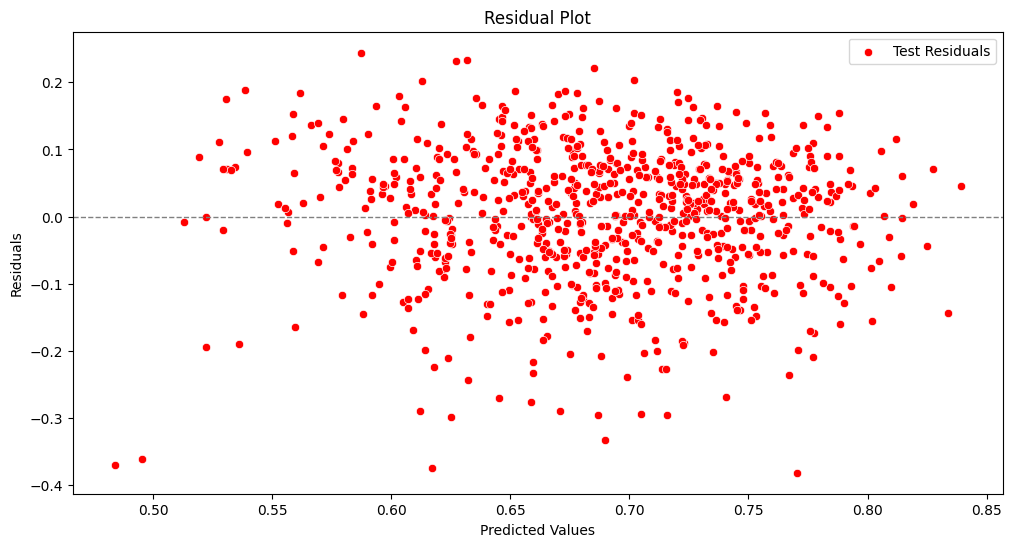

In [ ]:
# Calculate residuals (errors) for both training and test sets by subtracting predictions from true values.
# Plot residuals of the test set against predicted values to visually assess model performance and check for patterns or biases.
# A horizontal line at zero helps identify how residuals are distributed around the ideal prediction.
train_residuals = y_train - preds_train
test_residuals = y_val - preds_test

plt.figure(figsize=(12, 6))
# sns.scatterplot(x=preds_train, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=preds_test, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()

In [ ]:
# Convert the scaled data back into a DataFrame using the original feature column names for better readability and further processing.

data_sub_scale = pd.DataFrame(data_sub_scale,columns=data_x_drop.columns)

In [ ]:
# Use the trained stacking model to predict target values on the scaled submission data.
# Extract the 'id' column from the submission dataset to associate predictions with their identifiers.
# Create a new DataFrame with 'id' and predicted 'quality_score', then save it as a CSV file without the index.
prd =model_lin.predict(data_sub_scale)
ids = data_sub['id']
df = pd.DataFrame({
     'id':ids,
    'quality_score':prd
})
df.to_csv('Best_res30.csv',index=False)

In [ ]:
# Save the trained stacking model and the scaler object to disk using joblib for later use or deployment.
# Files are stored with descriptive names indicating model type and performance for easy identification.
import joblib
joblib.dump(model_lin,'model/mybest_model_noize_0.10640.pk1')
joblib.dump(scale,'model/mybest_scale_noize_10640.pk1')